<div>
<img style="float:left; border-radius:50%" src="https://avatars2.githubusercontent.com/u/58553327?s=460&u=3276252f07fb379c248bc8c9ce344bfdcaed7c45&v=4" width="40px">
<a href="https://github.com/carlosholivan"><img src="https://www.sferalabs.cc/wp-content/uploads/github-logo.png" width=70px style="float: right;"></a>
</div>

<a name="top"></a>

# 1. BERNOULLI VAE <a name="top"></a>

In this notebook it is described how to compute different time-frequency inputs with <strong>compute_input_from_audiopath</strong> function.

Author: Carlos Hernández Oliván<br>
Last update: 7 November 2020
  

### Table of Contents <a name="index"></a>
 
1. [Short-Time Fourier Transform](#stft)
2. [Chroma from STFT](#chroma-stft)
3. [Constant Q-Transform](#cqt)
    
[References](#references)

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

# module for reading audiofile
from pydub import AudioSegment

from tqdm import tqdm

# split dataset
from sklearn.model_selection import train_test_split

#torch modules
import torch
import torch.utils.data
from torch.nn import functional as F
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset, Subset

import warnings
warnings.filterwarnings('ignore')

In [165]:
# model parameters
class Config:
    pass

class InputsConfig(Config):
    
    SAMPLING_RATE = 16000  #  Hz
    
    WINDOW_SIZE_MS = 40  # ms
    WINDOW_SIZE = int(WINDOW_SIZE_MS / 1000 * SAMPLING_RATE)
    
    #HOP_LENGTH_MS = 10  #  ms
    #HOP_LENGTH = int(HOP_LENGTH_MS / 1000 * SAMPLING_RATE)
    HOP_LENGTH = 512
    
    F_MIN = 32.70  #  minimum frequency in Hz
    BINS = 190
    BINS_PER_OCTAVE = 24
    
    
class ParamsConfig(Config):
    
    DATA_PATH = './data'
    TRAINED_MODELS_PATH = './trained_models'
    
    BATCH_SIZE  =  1
    NUM_CHANNELS = 2  # output channels after first convolution
    LEARNING_RATE = 1e-3
    NUM_EPOCHS = 100
    
    VAE_BETA = 1
    LATENT_DIMS = 2
    
    LOG_INTERVAL = 10
    SEED = 199

In [168]:
ParamsConfig(DATA_PATH)

NameError: name 'DATA_PATH' is not defined

## 1. Preprocessing data

In this part we'll create and store as .npy the audio representation we'd want to use as the input of our model.
The .npy files will be stored in data/ directory in our module and the name of the files will be the same as the audio files names.

In [3]:
def convert_mp3_to_wav(audio_file_path, delete_mp3=False):
    """This function converts an mp3 file to a wav file"""
    
    if audio_file_path.split(".",1)[1] == 'mp3':
        try:
            sound = AudioSegment.from_mp3(audio_file_path)
            audio_wav_file_path = audio_file_path.split(".",1)[0] + ".wav"
            new_sound = sound.export(audio_wav_file_path, format="wav") #convert to wav file
            print(audio_file_path, 'file converted from', audio_file_path.split(".",1)[1], 'to wav format')
            
            #delete mp3 file
            if delete_mp3:
                os.remove(audio_file_path)
                
            return audio_wav_file_path
                
        except:
            raise ValueError('File cannot be converted to wav')
    else:
        raise ValueError('Inserted file is not an mp3 file')

In [4]:
def compute_input(audio_file_path):
    """This function computes the centroid of an audio file given its path"""
    
    try:
        y, sr = librosa.load(audio_file_path, sr=None)  
        
    except:
        #Call convert_mp3_to_wav to convert mp3 to wav
        new_wav_path = convert_mp3_to_wav(audio_file_path)
        y, sr = librosa.load(new_wav_path, sr=None)   
        
    #centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    cqt = np.abs(librosa.cqt(y, 
                             hop_length=InputsConfig.HOP_LENGTH, 
                             fmin=InputsConfig.F_MIN, 
                             n_bins=InputsConfig.BINS, 
                             bins_per_octave=InputsConfig.BINS_PER_OCTAVE))
        
    return cqt

In [5]:
def store_inputs(dataset_path):
    
    """This function computes the centroids of all the audio files in dataset_path and
    stores them in data directory in our module."""
    
    data_path = './data'
    
    # Create data directory to store the input arrays
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    
    for (im_dirpath, im_dirnames, im_filenames) in os.walk(dataset_path): 
        for f in im_filenames:  # loop in files
            file_name = f.split(".",1)[0]
            new_path = os.path.join(data_path, file_name + '.npy')
            
            if os.path.exists(new_path):  # if file is already in data, skip it
                print(new_path, 'already exists')
                continue
            else:
                try:
                    audio_file_path = os.path.join(im_dirpath, f)  # get the audio file path
                    inputs = compute_input(audio_file_path)  # compute the centroid of the audio file
                    np.save(new_path, inputs)  # stores arrays in data directory

                except:
                    print('Skipping file:', f)
                    continue

Now we'll compute the centroids and save them in our data directory

In [29]:
dataset_path = '/media/carlos/FILES/INVESTIGACION/Datasets/London Philarmonic Orchestra/'
store_inputs(dataset_path)

Skipping file: banjo.zip
Skipping file: bass clarinet.zip
Skipping file: bassoon.zip
Skipping file: cello.zip
Skipping file: clarinet.zip
Skipping file: contrabassoon.zip
Skipping file: cor anglais.zip
Skipping file: flute.zip
Skipping file: french horn.zip
Skipping file: guitar.zip
Skipping file: mandolin.zip
Skipping file: oboe.zip
Skipping file: saxophone.zip
Skipping file: saxophone_Fs3_15_fortissimo_normal.mp3
Skipping file: trombone.zip
Skipping file: trumpet.zip
Skipping file: tuba.zip
Skipping file: viola.zip
Skipping file: viola_D6_05_piano_arco-normal.mp3
Skipping file: violin.zip
Skipping file: double bass.zip


## 2. Create Dataloader from London Philarmonic Orchestra Dataset

In [38]:
class AudioDataset(Dataset):

    def __init__(self, data_path, transforms=None):
        
        """
        Args
        ----
            data_path : Path to all the array files
            audio_file_path : Path of a single audio file
        """
        
        self.data_path = data_path
        self.input_data = []
        self.files_path = []
        
        for (im_dirpath, im_dirnames, im_filenames) in os.walk(self.data_path): 
            for f in im_filenames:  # loop in files
                if f.split(".",1)[1] == 'npy':
                    input_file_path = os.path.join(im_dirpath, f)  # get the audio file path
                    input_file_data = np.load(input_file_path) # load npy file
                    
                    # append variables to lists
                    self.input_data.append(input_file_data)
                    self.files_path.append(input_file_path)
    
    def __len__(self):
        """count audio files"""
        return len(self.input_data)

    def __getitem__(self, index):
        """take audio file form list"""
                
        input_data = self.input_data[index]
        input_data = input_data[np.newaxis, :, :]  # add axis for batch
        
        audio_file = self.files_path[index]
        
        data = {
                'file': os.path.split(audio_file)[1].split('.')[0], 
                'input': input_data
                }

        return data

Now we can build our data loaders:

In [39]:
# testing Dataloader
train_dataset = AudioDataset(data_path=ParamsConfig.DATA_PATH)
train_trainloader = DataLoader(train_dataset, batch_size = ParamsConfig.BATCH_SIZE, num_workers=0)

In [40]:
print('Number of files in the training dataset:', len(train_dataset))

# Get a sample of the dataset
dataiter = iter(train_trainloader)
data = dataiter.next()
print(type(data))
print(data['file'])
print(data['input'].shape)

Number of files in the training dataset: 13681
<class 'dict'>
['cello_C6_15_fortissimo_arco-normal']
torch.Size([1, 1, 190, 167])


In [172]:
len(train_dataloader.dataset)

13681

We can plot one sample of the dataset:

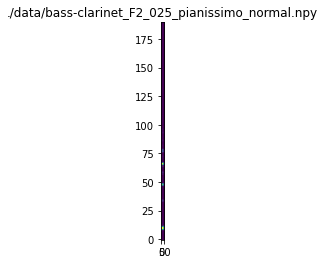

In [41]:
fig, ax = plt.subplots()
ax.imshow(train_dataset.input_data[700], cmap='viridis', interpolation='none', aspect=20, origin='lower')
ax.set_title(train_dataset.files_path[700])
plt.show()

In [43]:
data['input'].view(data['input'].size(0), -1).shape

torch.Size([1, 31730])

## 3. VAE Model

In [158]:
class Encoder(nn.Module):
    def __init__(self, num_channels=ParamsConfig.NUM_CHANNELS, latent_dims=ParamsConfig.LATENT_DIMS):
        super(Encoder, self).__init__()
        
        self.num_channels = num_channels
        self.latent_dims = latent_dims
        
        self.conv1 = nn.Conv2d(in_channels = 1, 
                               out_channels = self.num_channels*32, 
                               kernel_size = (5,5), 
                               stride = (1,1), 
                               padding = ((5 - 1) // 2, (5 - 1) // 2))
        
        self.pool1 = nn.MaxPool2d(kernel_size=(5,3), stride=(5,1), padding=(1,1))
        
        self.conv2 = nn.Conv2d(in_channels = self.num_channels, 
                               out_channels = self.num_channels*64, 
                               kernel_size = (3,3), 
                               stride = (1,1), 
                               padding = ((3 - 1) // 2, (3 - 1)*3 // 2),
                               dilation = (1,3))
        
        self.fc_mu = nn.Conv1d(in_channels = self.num_channels*64, 
                               out_channels = self.latent_dims,
                               kernel_size = 1)
        
        self.fc_logvar = nn.Conv1d(in_channels = self.num_channels*64, 
                                   out_channels = self.latent_dims,
                                   kernel_size = 1)
        
    def forward(self, x):
        print('Input size to Conv1 encoder:', x.shape)
        x = F.relu(self.conv1(x))
        print('Output size Conv1 encoder', x.shape)
        x = self.pool1(x)
        print('Output size after mx-pool1', x.shape)
        x = F.relu(self.conv2(x))
        print('Output size Conv2 encoder', x.shape)
        x = x.view(1, -1, x.size(3)) # flatten batch of multi-channel feature maps
        print('Output size after flatten', x.shape)
        
        x_mu = self.fc_mu(x)
        print('Output size of mu after fc', x_mu.shape)
        x_logvar = self.fc_logvar(x)
        print('Output size of logvar after fc', x_logvar.shape)
        return x_mu, x_logvar

In [159]:
m = nn.Linear(64*2*7*7, 2)
input = torch.randn(128, 64*2*7*7)
output = m(input)
print(output.size())

torch.Size([128, 2])


In [160]:
class Decoder(nn.Module):
    def __init__(self, num_channels=ParamsConfig.NUM_CHANNELS):
        super(Decoder, self).__init__()
        
        self.num_channels = num_channels
        
        self.fc = nn.Linear(in_features = ParamsConfig.LATENT_DIMS, 
                            out_features = self.num_channels*2*7*7)
        
        self.conv2 = nn.ConvTranspose2d(in_channels = self.num_channels*2, 
                                        out_channels = self.num_channels, 
                                        kernel_size = (4, 4), 
                                        stride = 2, 
                                        padding = 1)
        
        self.conv1 = nn.ConvTranspose2d(in_channels = self.num_channels, 
                                        out_channels = 1, 
                                        kernel_size = (4, 4), 
                                        stride = 2, 
                                        padding = 1)
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), self.num_channels*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

In [161]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class Unflatten(nn.Module):
    def __init__(self, channel, height, width):
        super(Unflatten, self).__init__()
        self.channel = channel
        self.height = height
        self.width = width

    def forward(self, input):
        return input.view(input.size(0), self.channel, self.height, self.width)


class ConvVAE(nn.Module):

    def __init__(self, latent_size):
        super(ConvVAE, self).__init__()

        self.latent_size = latent_size

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            Flatten(),
            nn.Linear(6272, 1024),
            nn.ReLU()
        )

        # hidden => mu
        self.fc1 = nn.Linear(1024, self.latent_size)

        # hidden => logvar
        self.fc2 = nn.Linear(1024, self.latent_size)

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 6272),
            nn.ReLU(),
            Unflatten(128, 7, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = self.fc1(h), self.fc2(h)
        return mu, logvar

    def decode(self, z):
        z = self.decoder(z)
        return z

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
from torchsummary import summary

channels = 1
h = train_dataset.input_data[700].shape[0]
w = train_dataset.input_data[700].shape[1]

summary(VAE(), input_size=(channels, h, w))

<div>
    
<button type="button" class="btn btn-primary" style="float:left; background-color:#a273f9; border:0"><a href="#top" style="color:white; text-decoration: none">⇦ Back to Top</a></button>
    
</div>

## 4. Loss<a name="loss"></a>

In [50]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(p_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(p_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

## 5. TRAIN FUNCTION<a name="train"></a>

In [51]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_dataset)/dataloader.batch_size)):
        data = data['input']
        data = data.to(device)

        # backprop
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        total_loss = loss(bce_loss, mu, logvar)
        running_loss += total_loss.item()
        total_loss.backward()
        
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

### 5. VALIDATION FUNCTION<a name="val"></a>

In [52]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_dataset)/dataloader.batch_size)):
            data = data['input']
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            total_loss = loss(bce_loss, mu, logvar)
            running_loss += total_loss.item()
  
            # save the last batch input and output of every epoch
            if i == int(len(val_dataset)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(ParamsConfig.BATCH_SIZE, 1, 28, 28)[:8], 
                                  reconstruction.view(ParamsConfig.BATCH_SIZE, 1, 28, 28)[:8]))
                save_image(both.cpu(), f"./outputs/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

### 6. RUN TRAINING FUNCTION<a name="training"></a>

In [53]:
# Dataloader
train_dataset = AudioDataset(data_path=ParamsConfig.DATA_PATH)
train_dataloader = DataLoader(train_dataset, batch_size = ParamsConfig.BATCH_SIZE, num_workers=0)

val_dataset = AudioDataset(data_path=ParamsConfig.DATA_PATH)
val_dataloader = DataLoader(val_dataset, batch_size=ParamsConfig.BATCH_SIZE, num_workers=0)

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
torch.cuda.is_available()

False

In [163]:
model = VAE().to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

optimizer = optim.Adam(model.parameters(), lr=ParamsConfig.LEARNING_RATE)

Number of parameters: 5363


In [56]:
model

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=6272, out_features=2, bias=True)
    (fc_logvar): Linear(in_features=6272, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=2, out_features=6272, bias=True)
    (conv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv1): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [164]:
train_loss = []
val_loss = []

if not os.path.exists(ParamsConfig.TRAINED_MODELS_PATH):
    os.mkdir(ParamsConfig.TRAINED_MODELS_PATH)
    
for epoch in range(ParamsConfig.NUM_EPOCHS):
    print(f"Epoch {epoch+1} of {ParamsConfig.NUM_EPOCHS}")
    train_epoch_loss = fit(model, train_dataloader)
    val_epoch_loss = validate(model, val_dataloader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")
    
    #save trained model every 5 epochs
    if epoch % 5 == 0:
        torch.save(model.state_dict(), 
                   os.path.join(ParamsConfig.TRAINED_MODELS_PATH, saved_model_ + str(epoch) + "epochs.bin"))

  0%|          | 0/13681 [00:00<?, ?it/s]

Epoch 1 of 100
Input size to Conv1 encoder: torch.Size([1, 1, 190, 167])
Output size Conv1 encoder torch.Size([1, 64, 190, 167])
Output size after mx-pool1 torch.Size([1, 64, 38, 167])


RuntimeError: Given groups=1, weight of size [128, 2, 3, 3], expected input[1, 64, 38, 167] to have 2 channels, but got 64 channels instead

In [76]:
shape = (1, 128, 47, 41)
tensor_4D = torch.randn(shape)
print(tensor_4D.shape)
print(tensor_4D.view(1, -1, tensor_4D.size(3)).shape)

torch.Size([1, 128, 47, 41])
torch.Size([1, 6016, 41])


### 7. VISUALIZE RECONSTRUCTIONS<a name="visualize"></a>

In [ ]:
from IPython.display import Image

fig = imageio.mimsave('./images/recon_tracking1.gif', 
                      viz_helper_20d.recon_tracking_imgs[::5], duration=.05)

Image(filename="./images/recon_tracking1.gif")

In [ ]:
fig2 = imageio.mimsave('./images/recon_tracking2.gif',
                       viz_helper_20d.recon_tracking_imgs[:150:1], duration=.1)
Image(filename="./images/recon_tracking2.gif")

## 2. 2D LATENT SPACE VAE<a name="2d"></a>

In [ ]:
viz_helper_2d = VAEVizHelper(recon_base_imgs)

In [ ]:
model = BernoulliVAE(data_size=784, encoder_szs=[400,150], latent_size=2,
                     decoder_szs=[150,400]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
model

In [ ]:
fit(model, 10, 10, viz_helper_2d, device=device)

In [ ]:
imageio.mimsave('./images/recon_tracking2d.gif', 
                viz_helper_2d.datagen_tracking_imgs[::5], duration=.05)
Image(filename="./images/recon_tracking2d.gif")

In [ ]:
imageio.mimsave('./images/recon_tracking2d_early.gif',
                viz_helper_2d.datagen_tracking_imgs[:200:2], duration=.1)
Image(filename="./images/recon_tracking2d_early.gif")

In [ ]:
plt.imshow(viz_helper_2d.datagen_tracking_imgs[-1])

In [ ]:
imageio.imwrite('./images/data_final.png', 
                viz_helper_2d.datagen_tracking_imgs[-1])

### References <a name="references"></a>

* Adam Lineberry: [GiHub](https://github.com/alineberry/alcore/blob/master/notebooks/VAE.ipynb) [Blog](http://adamlineberry.ai/vae-series/vae-code-experiments)

<div>
    
<button type="button" class="btn btn-primary" style="float:left; background-color:#a273f9; border:0"><a href="#top" style="color:white; text-decoration: none">⇦ Back to Top</a></button>

<button type="button" class="btn btn-primary" style="float:right; background-color:#BA55D3; border:0"><a href="2-chord_prediction.ipynb" style="color:white; text-decoration: none">Go to Chord Detection ⇒</a></button>
    
</div>